In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
trainDir = r"/home/trojan/Desktop/dimentia/data_10slices/dataset with PGGAN/train"
input_shape = Input(shape=(256, 256, 3))
dropout_rate = 0.2
batch_size = 8

In [3]:
def lr_schedule(epoch):
    lr = 1e-4 #1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(trainDir, target_size=(256, 256), batch_size=batch_size, 
                                                    class_mode='categorical', color_mode='rgb',
                                                   subset='training')

validation_generator = train_datagen.flow_from_directory(trainDir, target_size=(256, 256), batch_size=batch_size,
                                                     class_mode='categorical', color_mode='rgb',
                                                        subset='validation')

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 15743 images belonging to 2 classes.
Found 3934 images belonging to 2 classes.


In [5]:
resized_top = tf.keras.layers.experimental.preprocessing.Resizing(512, 512, interpolation='bilinear')(input_shape)
cnn_top = Conv2D(32, (5,5), padding='same', activation='relu')(resized_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(512, (3,3), padding='same', activation='relu',)(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Flatten()(cnn_top)
cnn_top = Dense(256)(cnn_top)


cnn_mid = Conv2D(32, (5,5), padding='same', activation='relu')(input_shape)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(512, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Flatten()(cnn_mid)
cnn_mid = Dense(256)(cnn_mid)

resized_bot = tf.keras.layers.experimental.preprocessing.Resizing(128, 128, interpolation='bilinear')(input_shape)
cnn_bot = Conv2D(32, (5,5), padding='same', activation='relu')(resized_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(512, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Flatten()(cnn_bot)
cnn_bot = Dense(256)(cnn_bot)

In [6]:
merged_model = concatenate([cnn_top, cnn_mid, cnn_bot])

#final_model = Dropout(dropout_rate)(merged_model)
final_model = BatchNormalization()(merged_model)
final_model = Dense(128)(merged_model)
#final_model = Dropout(dropout_rate)(final_model)
final_model = BatchNormalization()(final_model)
final_model = Dense(2)(final_model)
final_model = Activation('softmax')(final_model)

final_model = Model(input_shape, final_model)

In [7]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.summary()

Learning rate:  0.0001
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 2432        resizing[0][0]                   
________________________________________________________________

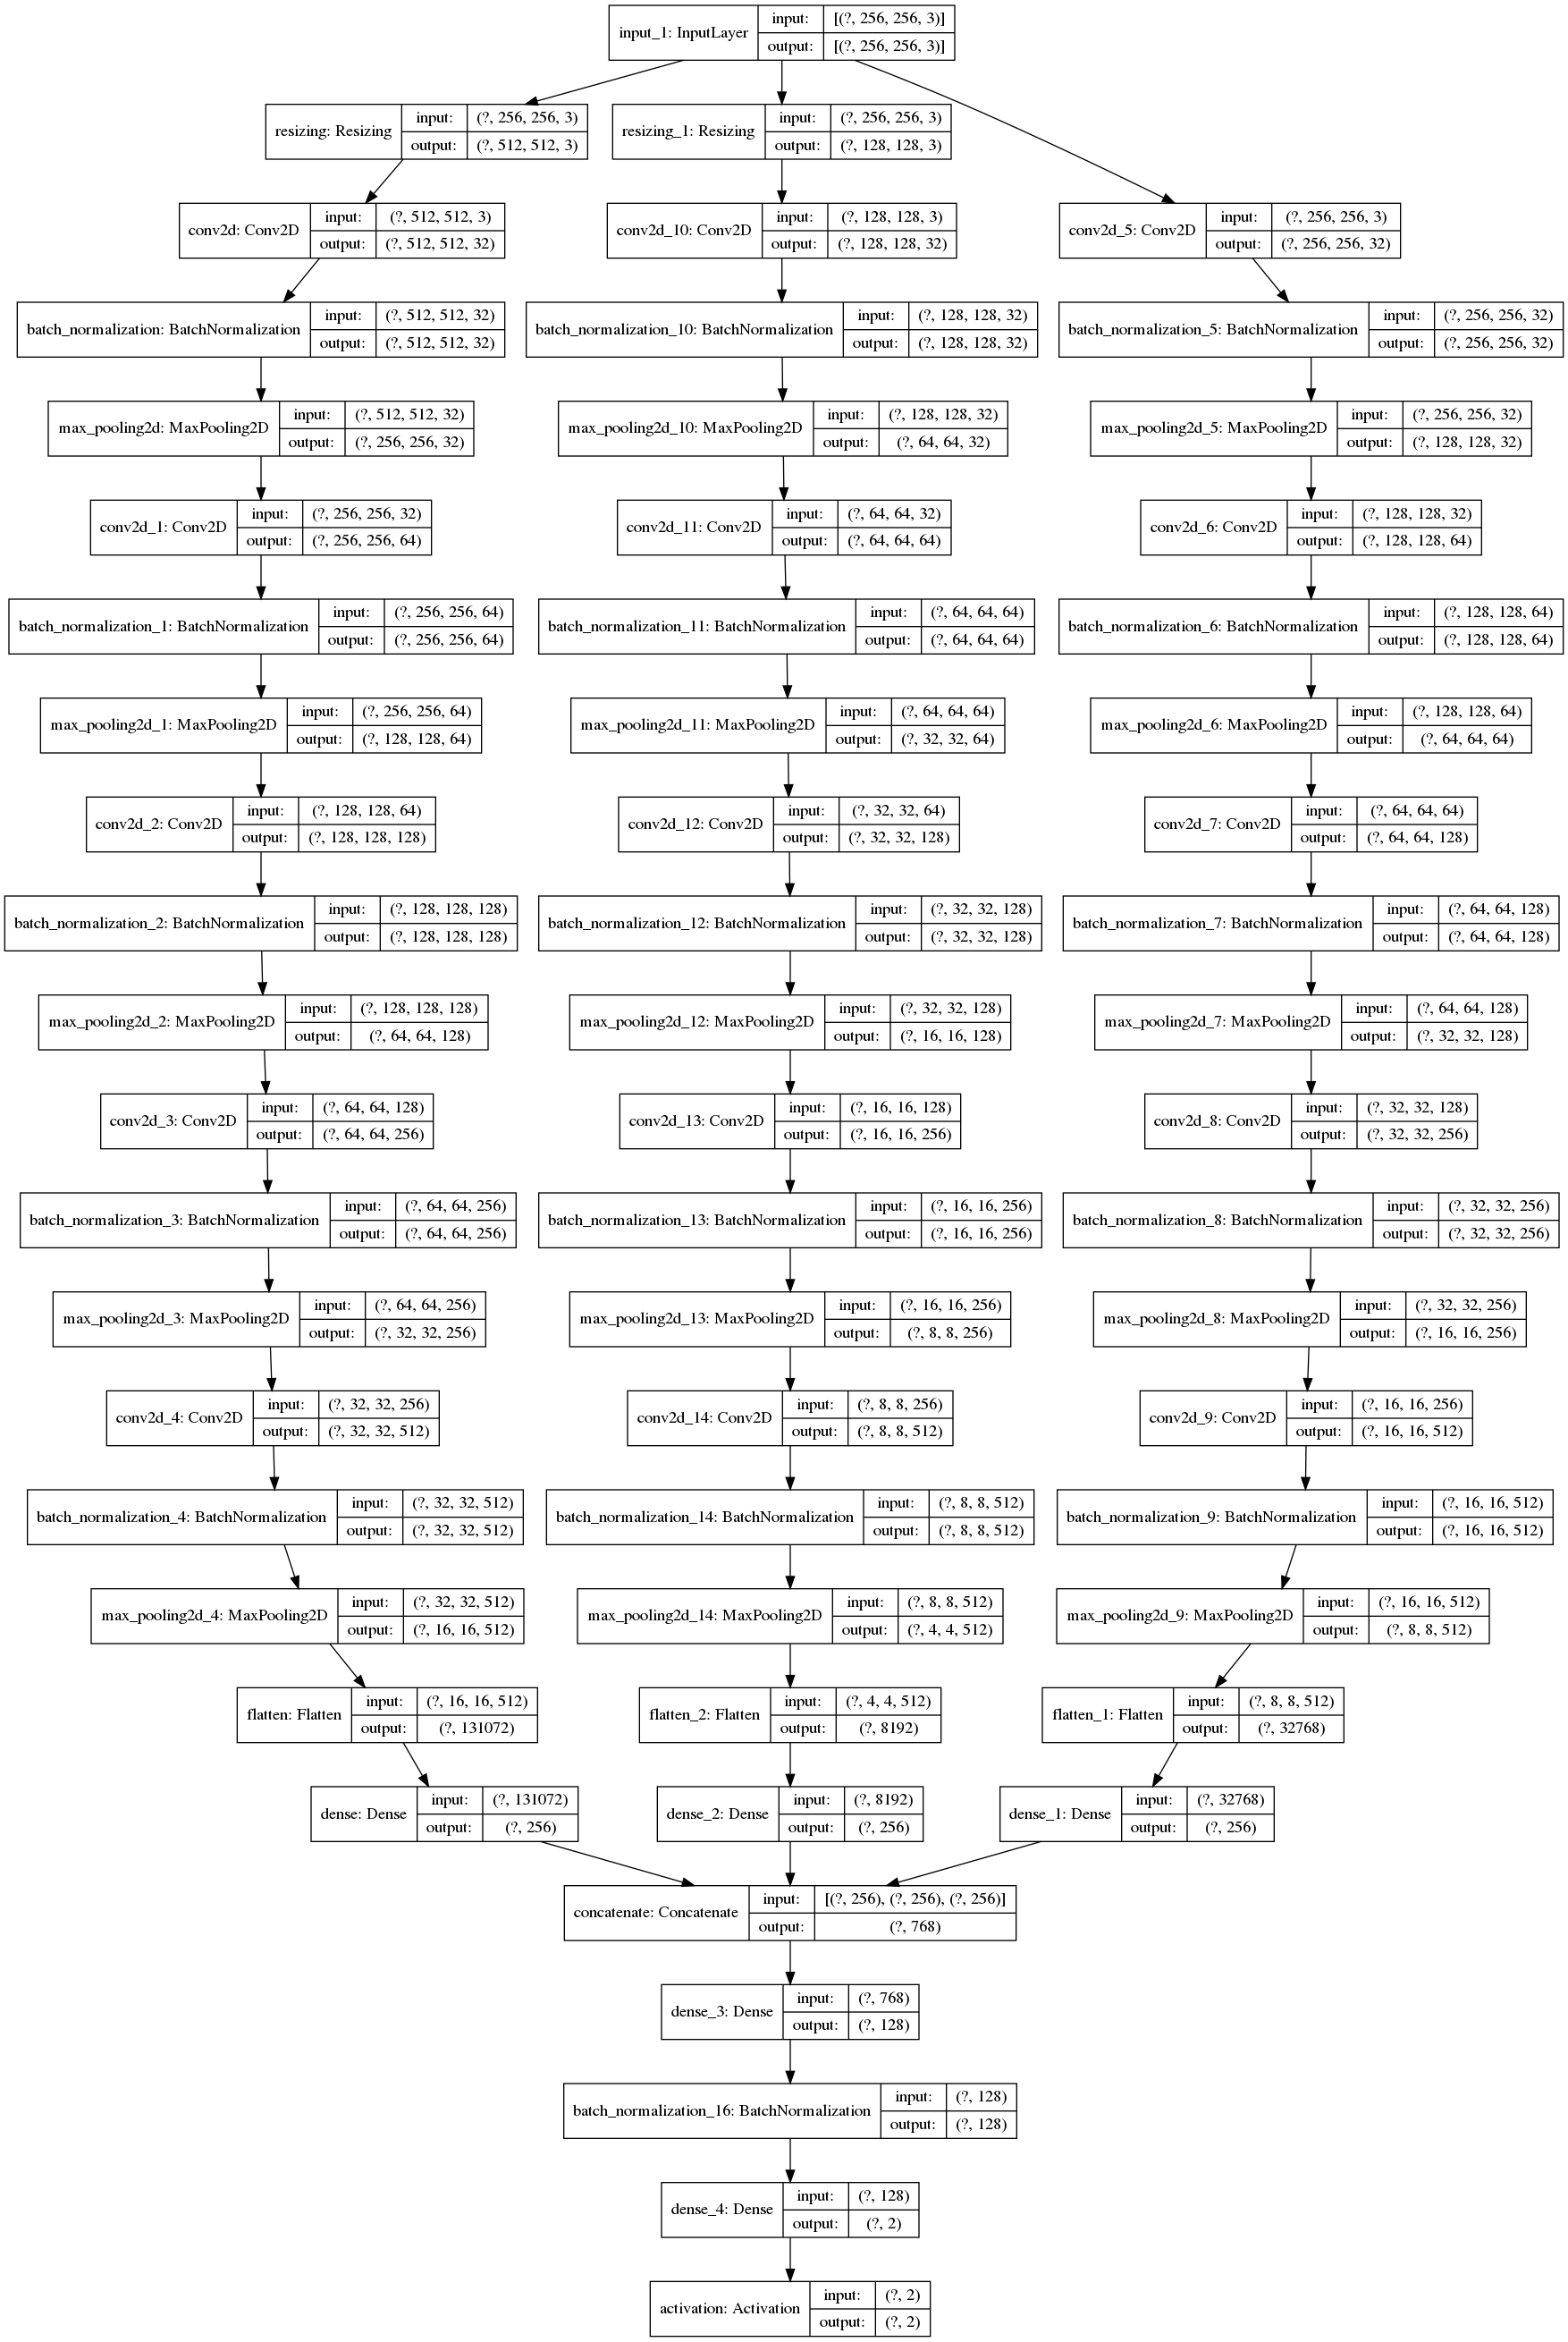

In [8]:
tf.keras.utils.plot_model(final_model, to_file='my_model.png', show_shapes=True)

In [9]:
checkpoint = ModelCheckpoint('best_model_method2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
#final_train_generator = zip(train_generator, train_generator, train_generator)
#final_test_generator  = zip(test_generator, test_generator, test_generator)
final_model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=50,
                          validation_data=validation_generator, verbose=1, workers=1, 
                          validation_steps=STEP_SIZE_VALID, callbacks=checkpoint)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1967/1967 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.7713
Epoch 00001: val_accuracy improved from -inf to 0.76120, saving model to best_model_method2.h5
1967/1967 [==============================] - 284s 144ms/step - loss: 0.4681 - accuracy: 0.7713 - val_loss: 0.4946 - val_accuracy: 0.7612
Epoch 2/50
1967/1967 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8594
Epoch 00002: val_accuracy improved from 0.76120 to 0.88493, saving model to best_model_method2.h5
1967/1967 [==============================] - 290s 147ms/step - loss: 0.3179 - accuracy: 0.8594 - val_loss: 0.2690 - val_accuracy: 0.8849
Epoch 3/50
1967/1967 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9022
Epoch 00003: val_accuracy did not improve from 0.88493
1967/1967 [==============================] - 293s 149ms/step - loss: 0.2336 - accuracy: 0.9022 - val_loss: 1

1967/1967 [==============================] - 296s 150ms/step - loss: 0.0529 - accuracy: 0.9804 - val_loss: 0.0504 - val_accuracy: 0.9809
Epoch 27/50
1967/1967 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9807
Epoch 00027: val_accuracy did not improve from 0.98091
1967/1967 [==============================] - 281s 143ms/step - loss: 0.0520 - accuracy: 0.9807 - val_loss: 0.1584 - val_accuracy: 0.9440
Epoch 28/50
1967/1967 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9821
Epoch 00028: val_accuracy improved from 0.98091 to 0.98192, saving model to best_model_method2.h5
1967/1967 [==============================] - 283s 144ms/step - loss: 0.0490 - accuracy: 0.9821 - val_loss: 0.0539 - val_accuracy: 0.9819
Epoch 29/50
1967/1967 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9793
Epoch 00029: val_accuracy did not improve from 0.98192
1967/1967 [==============================] - 280s 142ms/step - loss: 0.0570 - accura

In [7]:
from tensorflow.keras.models import load_model
model = load_model('best_model_method2.h5')

In [8]:
score = model.evaluate_generator(generator=validation_generator, verbose=1,
steps=STEP_SIZE_VALID)

print("Loss: ", score[0], "Accuracy: ", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
491/491 [==============================] - 16s 33ms/step - loss: 0.0272 - accuracy: 0.9903
Loss:  0.027151376008987427 Accuracy:  0.9903258681297302
